# Day 5
5, 100

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [15]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
inputPipe, outputPipe = getPreProcPipes(normIn=True)
classModel = 'modelSwish-5-100'
varSet = "basic_rot_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam', 'depth':5}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [17]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'val.hdf5', "r+")

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.634s 


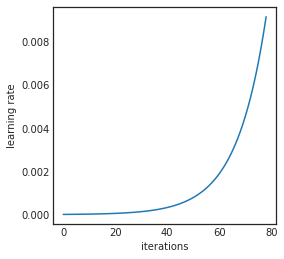

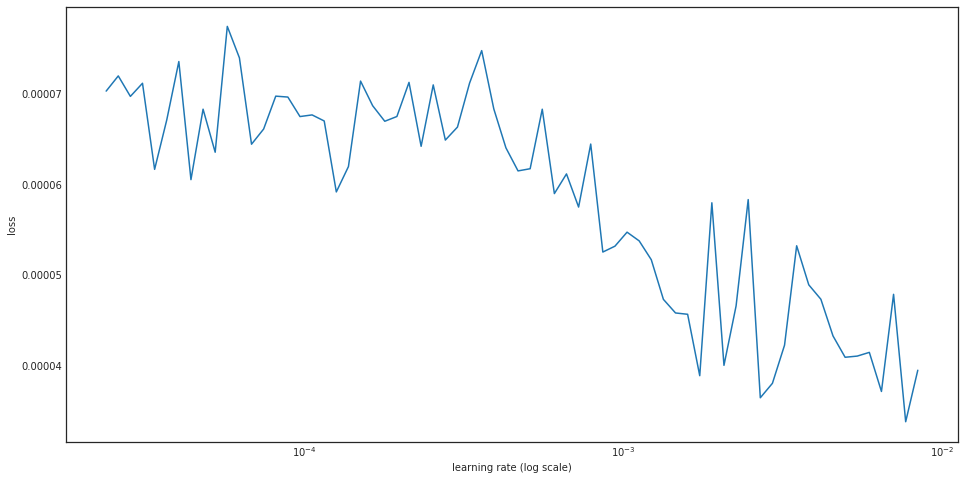

______________________________________



In [18]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,1e-2], trainOnWeights=True, verbose=0)

In [29]:
compileArgs['lr'] = 5e-3

## Train classifier

In [ ]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, patience=200, cosAnnealMult=2, trainOnWeights=True, maxEpochs=maxEpochs, verbose=1)

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode



/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189407). Check your callbacks.
  % delta_t_median)


1 New best found: 3.62886674849e-05
2 New best found: 3.49331568349e-05
3 New best found: 3.35346331202e-05
5 New best found: 3.28987799183e-05
6 New best found: 3.28559069525e-05
7 New best found: 3.24028337949e-05
13 New best found: 3.21401809239e-05
14 New best found: 3.19875629741e-05
15 New best found: 3.1978690037e-05
25 New best found: 3.19575507992e-05
26 New best found: 3.17825982495e-05
28 New best found: 3.17567498547e-05
29 New best found: 3.17075281953e-05
30 New best found: 3.16486235867e-05
31 New best found: 3.16451819064e-05
54 New best found: 3.16411917266e-05
56 New best found: 3.16352643183e-05
57 New best found: 3.16204975296e-05
59 New best found: 3.15370821871e-05
60 New best found: 3.15229774196e-05
61 New best found: 3.151532916e-05
63 New best found: 3.1515047869e-05


## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on development data

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

In [ ]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData), getFeature('pred', valData)),
                                                           roc_auc_score(getFeature('targets', valData), getFeature('pred', valData), sample_weight=getFeature('weights', valData)))

## Evaluation

### Import in dataframe

In [ ]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [ ]:
valframe = convertToDF(valData)

In [ ]:
sigVal = (valframe.gen_target == 1)
bkgVal = (valframe.gen_target == 0)

### MVA distributions

In [ ]:
getClassPredPlot([valframe[bkgVal], valframe[sigVal]], weightName='gen_weight')

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        if scale:
            s *= scale[0]/np.sum(inData[(inData['gen_target'] == 1)]['gen_weight'])
            b *= scale[1]/np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

In [ ]:
def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
valframe['ams'] = amsScan(valframe)[0]

In [ ]:
bests = foldAMSScan(valframe, 10)

In [ ]:
def chooseCut(inData, n=1000):
    boot = []
    for i in xrange(n):
        points = np.random.choice(inData.index.tolist(), int(0.1*len(inData)), replace=False)
        boot.append(inData.loc[points].loc[np.argmax(inData.loc[points]['ams'])]['pred_class'])
    print np.mean(boot)

In [ ]:
chooseCut(valData[(valData.pred_class >= 0.90) & (valData.pred_class <= 0.96)])

In [ ]:
def scoreTest(ensemble, weights):
    testData = h5py.File(dirLoc + 'testing.hdf5', "r+")
    batchEnsemblePredict(ensemble, weights, testData, ensembleSize=10, verbose=1)

def saveTest(cut, name):
    testData = h5py.File(dirLoc + 'testing.hdf5', "r+")
    
    data = pandas.DataFrame()
    data['EventId'] = getFeature('EventId', testData)
    data['pred_class'] = getFeature('pred', testData)
    
    data['Class'] = 'b'
    data.loc[data.pred_class >= cut, 'Class'] = 's'

    data.sort_values(by=['pred_class'], inplace=True)
    data['RankOrder']=range(1, len(data)+1)
    data.sort_values(by=['EventId'], inplace=True)

    print dirLoc + name + '_test.csv'
    data.to_csv(dirLoc + name + '_test.csv', columns=['EventId', 'RankOrder', 'Class'], index=False)

In [ ]:
scoreTest(ensemble, weights)

In [ ]:
def saveTest(cut, name):
    testData = h5py.File(dirLoc + 'testing.hdf5', "r+")
    
    data = pandas.DataFrame()
    data['EventId'] = getFeature('EventId', testData)
    data['pred_class'] = getFeature('pred', testData)
    
    data['Class'] = 'b'
    data.loc[data.pred_class >= cut, 'Class'] = 's'

    data.sort_values(by=['pred_class'], inplace=True)
    data['RankOrder']=range(1, len(data)+1)
    data.sort_values(by=['EventId'], inplace=True)

    print dirLoc + name + '_test.csv'
    data.to_csv(dirLoc + name + '_test.csv', columns=['EventId', 'RankOrder', 'Class'], index=False)

In [ ]:
saveTest(0.9519652820188802, 'Day_4')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_4_test.csv -m"Day_4_Basic_Features_256_1e-3_swish_mult2_60E_normedweighted_rot_cart_999->-1, fold mean inverse weighted 100"